In [25]:
#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [26]:
#Fetch Images count from Fodlers

In [27]:
import os

count = 0
dirs = os.listdir('/Users/anushakurra/Flower_recog_Model/Images')
for dir in dirs:
    if not dir.startswith('.'):  # This will skip hidden files like .DS_Store
        files = list(os.listdir('/Users/anushakurra/Flower_recog_Model/Images/' + dir))
        print(dir + ' Folder has ' + str(len(files)) + ' Images')
        count += len(files)

print('Total image count:', count)


daisy Folder has 764 Images
rose Folder has 784 Images
tulip Folder has 984 Images
dandelion Folder has 787 Images
sunflower Folder has 733 Images
Total image count: 4052


In [28]:
#Load Images into Arrays as Dataset

In [29]:
base_dir = '/Users/anushakurra/Flower_recog_Model/Images/'
img_size = 180
batch = 32

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4051 files belonging to 5 classes.
Using 3241 files for training.
Found 4051 files belonging to 5 classes.
Using 810 files for validation.


In [31]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [32]:
import matplotlib.pyplot as plt

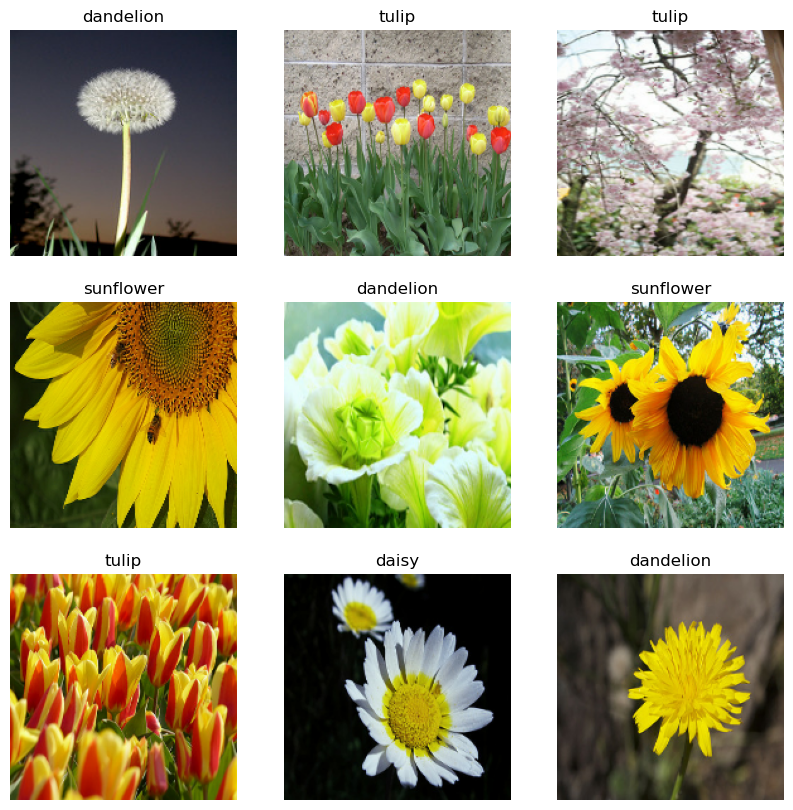

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')
plt.show()

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
#Data Augmentation

In [37]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

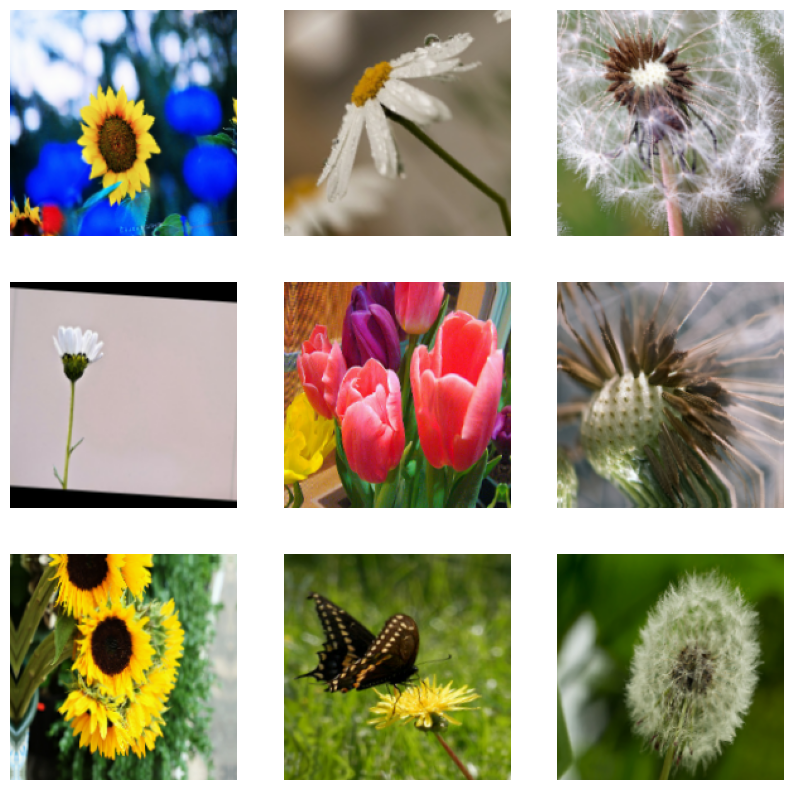

In [38]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype('uint8'))
        plt.axis('off')
plt.show()

In [39]:
#MOdel Creation

In [40]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])


In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)       

In [48]:
history = model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
102/102 [==============================] - 19s 182ms/step - loss: 0.0921 - accuracy: 0.9735 - val_loss: 2.6559 - val_accuracy: 0.5160
Epoch 2/25
102/102 [==============================] - 16s 157ms/step - loss: 0.0419 - accuracy: 0.9911 - val_loss: 2.9064 - val_accuracy: 0.5691
Epoch 3/25
102/102 [==============================] - 19s 185ms/step - loss: 0.0394 - accuracy: 0.9904 - val_loss: 2.9511 - val_accuracy: 0.5321
Epoch 4/25
102/102 [==============================] - 18s 175ms/step - loss: 0.0633 - accuracy: 0.9830 - val_loss: 3.0284 - val_accuracy: 0.5025
Epoch 5/25
102/102 [==============================] - 19s 183ms/step - loss: 0.1004 - accuracy: 0.9756 - val_loss: 2.8541 - val_accuracy: 0.5000
Epoch 6/25
102/102 [==============================] - 17s 164ms/step - loss: 0.0664 - accuracy: 0.9812 - val_loss: 2.9778 - val_accuracy: 0.5173
Epoch 7/25
102/102 [==============================] - 18s 172ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 3.1833 - val_ac

In [56]:
model.save('saved_model/flower_recog_model', save_format='tf')

INFO:tensorflow:Assets written to: saved_model/flower_recog_model/assets


INFO:tensorflow:Assets written to: saved_model/flower_recog_model/assets


In [57]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_array = input_image_array / 255.0  # Rescale
    input_image_exp_dim = tf.expand_dims(input_image_array, 0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = f'The Image belongs to {flower_names[np.argmax(result)]} with a score of {np.max(result) * 100:.2f}%'
    return outcome


In [58]:
classify_images('Sample/sunflower.jpeg')

1/1 [==============================] - 0s 19ms/step


'The Image belongs to dandelion with a score of 99.58%'

In [59]:
import os

base_dir = '/Users/anushakurra/Flower_recog_Model/Images'
for dir in os.listdir(base_dir):
    if not dir.startswith('.'):
        count = len(os.listdir(os.path.join(base_dir, dir)))
        print(f"{dir}: {count} images")


daisy: 764 images
rose: 784 images
tulip: 984 images
dandelion: 787 images
sunflower: 733 images


In [60]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.14.0
2.14.0
